# SSBH Dataset Train/Valid/Test Splitting

This notebook performs the train/valid/test splitting of the preprocessed SSBH dataset with:
- **70% Train / 10% Validation / 20% Test** split
- **Random shuffling** before splitting to ensure unbiased distribution
- **Stratified approach** to maintain data quality across splits
- **Organized output** into `prep_split` folder structure

**Input**: `preprocessed/` folder with rgb, height, mask modalities  
**Output**: `prep_split/` folder with train/valid/test splits containing rgb, dsm, sem subfolders

**Folder Mapping**:
- `rgb/` → `rgb/` (RGB composite images)
- `height/` → `dsm/` (Digital Surface Model - building heights)  
- `mask/` → `sem/` (Semantic segmentation masks - building masks)

## 1. Setup Environment and Imports

Import necessary libraries for data handling, file operations, and visualization.

In [14]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from typing import List, Tuple, Dict
import rasterio
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Rasterio version: {rasterio.__version__}")

Libraries imported successfully!
NumPy version: 2.0.2
Rasterio version: 1.4.3


## 2. Define Paths and Configuration

Set up paths and splitting configuration parameters.

In [ ]:
# Dataset paths
BASE_PATH = Path(".")  # Current directory - assumes preprocessed/ folder is in same directory as this notebook
PREPROCESSED_PATH = BASE_PATH / "preprocessed"
OUTPUT_PATH = BASE_PATH / "prep_split"

# Splitting configuration
TRAIN_RATIO = 0.7   # 70% for training
VALID_RATIO = 0.1   # 10% for validation  
TEST_RATIO = 0.2    # 20% for testing

# Folder mapping from preprocessed to split structure
FOLDER_MAPPING = {
    'rgb': 'rgb',      # RGB composite images
    'height': 'dsm',   # Digital Surface Model (building heights)
    'mask': 'sem'      # Semantic segmentation masks (building masks)
}

# Split names
SPLITS = ['train', 'valid', 'test']
SPLIT_RATIOS = [TRAIN_RATIO, VALID_RATIO, TEST_RATIO]

print(f"Source (preprocessed): {PREPROCESSED_PATH.resolve()}")
print(f"Destination (split): {OUTPUT_PATH.resolve()}")
print(f"Split ratios: Train={TRAIN_RATIO:.0%}, Valid={VALID_RATIO:.0%}, Test={TEST_RATIO:.0%}")
print(f"Folder mapping: {FOLDER_MAPPING}")
print(f"Random seed: 42 (for reproducibility)")

Source (preprocessed): c:\Users\Ahmad\Desktop\Ozyegin University\research\projects\building height estimation\datasets\SSBH\_preprocessed
Destination (split): c:\Users\Ahmad\Desktop\Ozyegin University\research\projects\building height estimation\datasets\SSBH\_prep_split
Split ratios: Train=70%, Valid=10%, Test=20%
Folder mapping: {'rgb': 'rgb', 'height': 'dsm', 'mask': 'sem'}
Random seed: 42 (for reproducibility)


## 3. Data Discovery and Analysis

Discover all available samples and analyze the dataset before splitting.

In [16]:
def discover_samples(preprocessed_path: Path) -> List[str]:
    """
    Discover all available samples from the preprocessed dataset.
    
    Args:
        preprocessed_path: Path to preprocessed dataset
    
    Returns:
        List of sample names (without extension)
    """
    rgb_path = preprocessed_path / "rgb"
    
    if not rgb_path.exists():
        raise FileNotFoundError(f"RGB folder not found: {rgb_path}")
    
    # Get all RGB files as reference (assuming all modalities have same samples)
    rgb_files = list(rgb_path.glob("*.tif"))
    sample_names = [f.stem for f in rgb_files]
    
    return sorted(sample_names)

def validate_sample_completeness(preprocessed_path: Path, sample_names: List[str]) -> Dict[str, int]:
    """
    Validate that all samples have complete modalities (rgb, height, mask).
    
    Args:
        preprocessed_path: Path to preprocessed dataset
        sample_names: List of sample names to validate
    
    Returns:
        Dictionary with counts of complete/incomplete samples
    """
    modalities = ['rgb', 'height', 'mask']
    complete_samples = []
    incomplete_samples = []
    
    for sample_name in tqdm(sample_names, desc="Validating samples"):
        is_complete = True
        
        for modality in modalities:
            file_path = preprocessed_path / modality / f"{sample_name}.tif"
            if not file_path.exists():
                is_complete = False
                break
        
        if is_complete:
            complete_samples.append(sample_name)
        else:
            incomplete_samples.append(sample_name)
    
    return {
        'complete': len(complete_samples),
        'incomplete': len(incomplete_samples),
        'complete_samples': complete_samples,
        'incomplete_samples': incomplete_samples
    }

# Discover and validate samples
print("Discovering samples from preprocessed dataset...")
all_samples = discover_samples(PREPROCESSED_PATH)
print(f"Total samples found: {len(all_samples)}")

print("\nValidating sample completeness...")
validation_results = validate_sample_completeness(PREPROCESSED_PATH, all_samples)

print(f"\nValidation Results:")
print(f"  Complete samples: {validation_results['complete']}")
print(f"  Incomplete samples: {validation_results['incomplete']}")

if validation_results['incomplete'] > 0:
    print(f"\nIncomplete samples: {validation_results['incomplete_samples'][:10]}...")  # Show first 10
else:
    print("\n✓ All samples are complete!")

# Use only complete samples for splitting
complete_samples = validation_results['complete_samples']
print(f"\nUsing {len(complete_samples)} complete samples for splitting.")

Discovering samples from preprocessed dataset...
Total samples found: 5606

Validating sample completeness...


Validating samples: 100%|██████████| 5606/5606 [00:00<00:00, 11279.77it/s]


Validation Results:
  Complete samples: 5606
  Incomplete samples: 0

✓ All samples are complete!

Using 5606 complete samples for splitting.


## 4. Sample Shuffling and Splitting

Perform random shuffling and split samples into train/valid/test sets.

In [17]:
def shuffle_and_split_samples(samples: List[str], 
                             train_ratio: float = 0.8, 
                             valid_ratio: float = 0.1, 
                             test_ratio: float = 0.1) -> Dict[str, List[str]]:
    """
    Shuffle samples randomly and split into train/valid/test sets.
    
    Args:
        samples: List of sample names
        train_ratio: Proportion for training set
        valid_ratio: Proportion for validation set
        test_ratio: Proportion for test set
    
    Returns:
        Dictionary with 'train', 'valid', 'test' keys containing sample lists
    """
    # Validate ratios
    total_ratio = train_ratio + valid_ratio + test_ratio
    if abs(total_ratio - 1.0) > 1e-6:
        raise ValueError(f"Ratios must sum to 1.0, got {total_ratio}")
    
    # Shuffle samples randomly (with fixed seed for reproducibility)
    shuffled_samples = samples.copy()
    random.shuffle(shuffled_samples)
    
    total_samples = len(shuffled_samples)
    
    # Calculate split indices
    train_end = int(total_samples * train_ratio)
    valid_end = train_end + int(total_samples * valid_ratio)
    
    # Split samples
    train_samples = shuffled_samples[:train_end]
    valid_samples = shuffled_samples[train_end:valid_end]
    test_samples = shuffled_samples[valid_end:]
    
    splits = {
        'train': train_samples,
        'valid': valid_samples,
        'test': test_samples
    }
    
    # Print split statistics
    print(f"Split Statistics:")
    print(f"  Total samples: {total_samples}")
    print(f"  Train: {len(train_samples)} ({len(train_samples)/total_samples:.1%})")
    print(f"  Valid: {len(valid_samples)} ({len(valid_samples)/total_samples:.1%})")
    print(f"  Test: {len(test_samples)} ({len(test_samples)/total_samples:.1%})")
    
    return splits

def analyze_split_distribution(splits: Dict[str, List[str]]) -> None:
    """
    Analyze the distribution of samples across cuts in each split.
    
    Args:
        splits: Dictionary with train/valid/test sample lists
    """
    print(f"\nSplit Distribution Analysis:")
    print("-" * 50)
    
    for split_name, samples in splits.items():
        # Extract cut numbers from sample names (format: cut{XX}_{tile_id})
        cut_numbers = []
        for sample in samples:
            try:
                cut_part = sample.split('_')[0]  # Get 'cutXX' part
                cut_num = int(cut_part.replace('cut', ''))
                cut_numbers.append(cut_num)
            except:
                continue
        
        if cut_numbers:
            cut_numbers = sorted(cut_numbers)
            unique_cuts = sorted(set(cut_numbers))
            
            print(f"{split_name.upper()}:")
            print(f"  Samples: {len(samples)}")
            print(f"  Cuts represented: {len(unique_cuts)} (cut{min(unique_cuts):02d}-cut{max(unique_cuts):02d})")
            print(f"  Avg samples per cut: {len(samples)/len(unique_cuts):.1f}")
            print()

# Perform shuffling and splitting
print("Shuffling and splitting samples...")
sample_splits = shuffle_and_split_samples(
    complete_samples, 
    TRAIN_RATIO, 
    VALID_RATIO, 
    TEST_RATIO
)

# Analyze distribution
analyze_split_distribution(sample_splits)

Shuffling and splitting samples...
Split Statistics:
  Total samples: 5606
  Train: 3924 (70.0%)
  Valid: 560 (10.0%)
  Test: 1122 (20.0%)

Split Distribution Analysis:
--------------------------------------------------
TRAIN:
  Samples: 3924
  Cuts represented: 67 (cut01-cut67)
  Avg samples per cut: 58.6

VALID:
  Samples: 560
  Cuts represented: 63 (cut02-cut67)
  Avg samples per cut: 8.9

TEST:
  Samples: 1122
  Cuts represented: 66 (cut01-cut67)
  Avg samples per cut: 17.0



## 5. Create Split Directory Structure

Create the directory structure for train/valid/test splits and copy files.

In [18]:
def create_split_directories(base_dir: Path) -> Dict[str, Path]:
    """Create directory structure for train/valid/test splits.
    
    Structure:
    base_dir/
    ├── train/
    │   ├── rgb/
    │   ├── dsm/
    │   └── sem/
    ├── valid/
    │   ├── rgb/
    │   ├── dsm/
    │   └── sem/
    └── test/
        ├── rgb/
        ├── dsm/
        └── sem/
    """
    splits = ['train', 'valid', 'test']
    modalities = ['rgb', 'dsm', 'sem']
    
    split_dirs = {}
    
    for split in splits:
        split_dir = base_dir / split
        split_dir.mkdir(parents=True, exist_ok=True)
        
        split_dirs[split] = {}
        for modality in modalities:
            modality_dir = split_dir / modality
            modality_dir.mkdir(parents=True, exist_ok=True)
            split_dirs[split][modality] = modality_dir
    
    print(f"Created directory structure in: {base_dir}")
    return split_dirs

# Create split directories
split_dirs = create_split_directories(OUTPUT_PATH)

Created directory structure in: c:\Users\Ahmad\Desktop\Ozyegin University\research\projects\building height estimation\datasets\SSBH\_prep_split


In [19]:
def copy_files_to_splits(samples_dict: Dict[str, List[str]], split_dirs: Dict[str, Dict[str, Path]]):
    """Copy files from preprocessed directory to split directories.
    
    Mapping:
    - rgb/ -> rgb/
    - height/ -> dsm/
    - mask/ -> sem/
    """
    modality_mapping = {
        'rgb': 'rgb',
        'height': 'dsm', 
        'mask': 'sem'
    }
    
    total_files = sum(len(samples) for samples in samples_dict.values()) * 3  # 3 modalities
    
    with tqdm(total=total_files, desc="Copying files") as pbar:
        for split_name, samples in samples_dict.items():
            for sample_id in samples:
                for src_modality, dst_modality in modality_mapping.items():
                    src_file = PREPROCESSED_PATH / src_modality / f"{sample_id}.tif"
                    dst_file = split_dirs[split_name][dst_modality] / f"{sample_id}.tif"
                    
                    if src_file.exists():
                        # Copy file
                        import shutil
                        shutil.copy2(src_file, dst_file)
                        pbar.update(1)
                    else:
                        print(f"Warning: Source file not found: {src_file}")
                        pbar.update(1)
    
    print("\nFile copying completed!")

# Use the splits that were already created
samples_dict = sample_splits

print(f"\nSplit summary:")
print(f"Train: {len(samples_dict['train'])} samples")
print(f"Valid: {len(samples_dict['valid'])} samples")
print(f"Test: {len(samples_dict['test'])} samples")

# Copy files to split directories
copy_files_to_splits(samples_dict, split_dirs)


Split summary:
Train: 3924 samples
Valid: 560 samples
Test: 1122 samples


Copying files: 100%|██████████| 16818/16818 [01:53<00:00, 148.03it/s]


File copying completed!


## 6. Visualization of Split Samples

Create a comprehensive visualization showing samples from each split.


Visualization saved to: c:\Users\Ahmad\Desktop\Ozyegin University\research\projects\building height estimation\datasets\SSBH\_prep_split\split_visualization.png


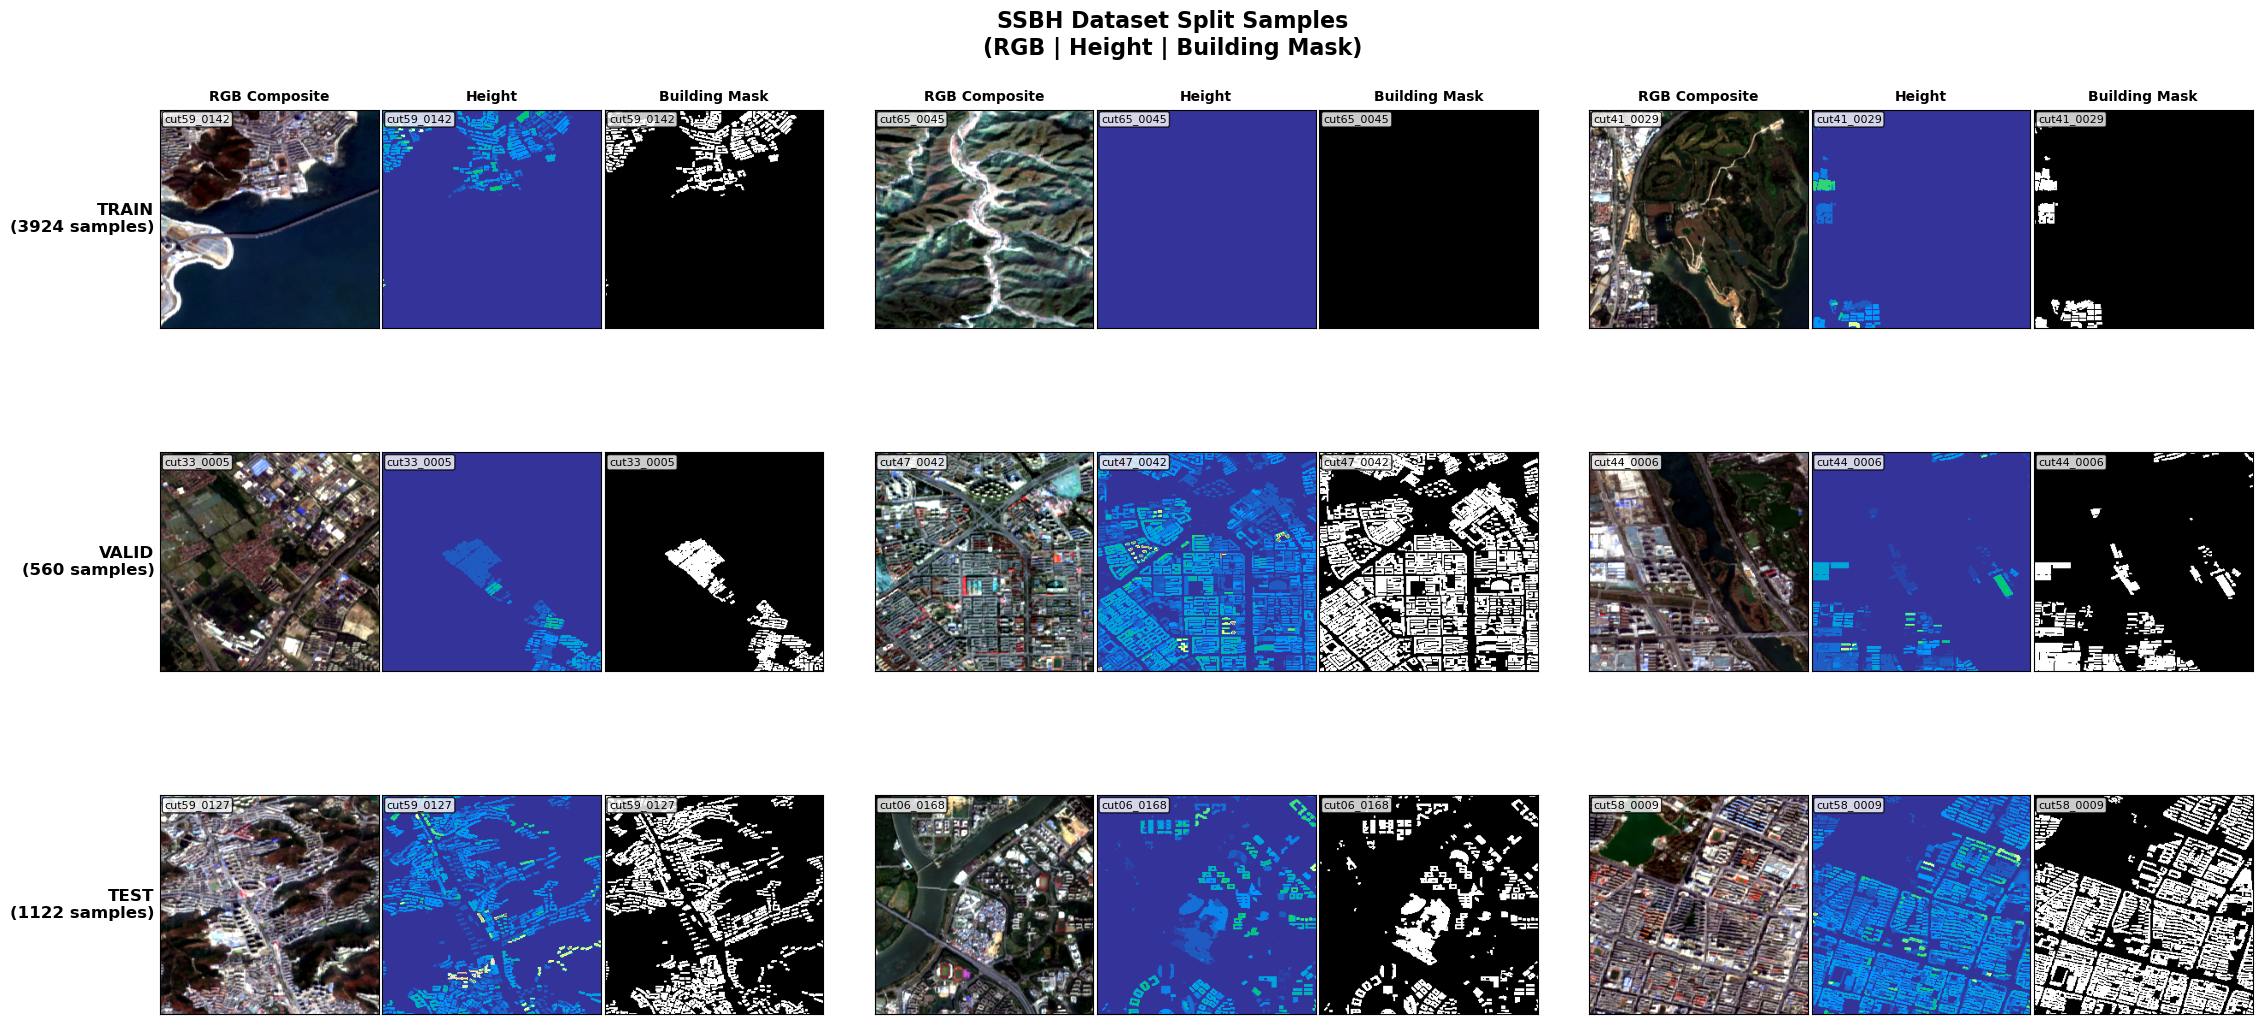

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_split_samples(samples_dict: Dict[str, List[str]], split_dirs: Dict[str, Dict[str, Path]], 
                          n_samples: int = 3):
    """Create a comprehensive visualization of samples from each split.
    
    Args:
        samples_dict: Dictionary with split names and sample lists
        split_dirs: Dictionary with split directory paths
        n_samples: Number of samples to show per split
    """
    # Create figure with custom spacing to separate sample groups
    fig = plt.figure(figsize=(n_samples * 9, 12))
    fig.suptitle('SSBH Dataset Split Samples\n(RGB | Height | Building Mask)', fontsize=16, fontweight='bold')
    
    splits = ['train', 'valid', 'test']
    modalities = ['rgb', 'dsm', 'sem']
    modality_titles = ['RGB Composite', 'Height', 'Building Mask']
    
    # Create custom grid with spacing between sample groups
    gs = fig.add_gridspec(3, n_samples * 3 + (n_samples - 1), 
                         width_ratios=[1, 1, 1] + [0.2, 1, 1, 1] * (n_samples - 1),
                         hspace=0.15, wspace=0.02)
    
    for split_idx, split_name in enumerate(splits):
        # Randomly select samples from this split
        selected_samples = random.sample(samples_dict[split_name], min(n_samples, len(samples_dict[split_name])))
        
        for sample_idx, sample_id in enumerate(selected_samples):
            for mod_idx, (modality, mod_title) in enumerate(zip(modalities, modality_titles)):
                # Calculate column index accounting for spacing
                col_idx = sample_idx * 4 + mod_idx if sample_idx > 0 else mod_idx
                
                ax = fig.add_subplot(gs[split_idx, col_idx])
                
                # Load and display image
                file_path = split_dirs[split_name][modality] / f"{sample_id}.tif"
                
                try:
                    with rasterio.open(file_path) as src:
                        data = src.read()
                        
                        if modality == 'rgb':
                            # RGB: transpose to HWC and normalize to 0-1
                            img = np.transpose(data, (1, 2, 0)).astype(np.float32)
                            img = np.clip(img / 65535.0, 0, 1)  # Normalize uint16 to float
                            ax.imshow(img)
                            
                        elif modality == 'dsm':
                            # Height: single band, use colormap
                            height_data = data[0]
                            # Mask invalid values
                            height_data = np.where(height_data == -9999, np.nan, height_data)
                            im = ax.imshow(height_data, cmap='terrain', vmin=0, vmax=100)
                            
                        elif modality == 'sem':
                            # Semantic mask: binary mask
                            mask_data = data[0]
                            ax.imshow(mask_data, cmap='gray', vmin=0, vmax=1)
                
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error loading\n{sample_id}', 
                           ha='center', va='center', transform=ax.transAxes)
                    print(f"Error loading {file_path}: {e}")
                
                # Set title and remove axes
                if split_idx == 0:  # Only show modality titles on top row
                    ax.set_title(f"{mod_title}", fontsize=10, fontweight='bold')
                
                if sample_idx == 0 and mod_idx == 0:  # Only show split label on leftmost column
                    ax.set_ylabel(f"{split_name.upper()}\n({len(samples_dict[split_name])} samples)", 
                                fontsize=12, fontweight='bold', rotation=0, ha='right', va='center')
                
                ax.set_xticks([])
                ax.set_yticks([])
                ax.text(0.02, 0.98, sample_id, transform=ax.transAxes, 
                       fontsize=8, va='top', ha='left', 
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    plt.subplots_adjust(top=0.93)
    
    # Save the figure
    output_fig = OUTPUT_PATH / 'split_visualization.png'
    plt.savefig(output_fig, dpi=300, bbox_inches='tight')
    print(f"\nVisualization saved to: {output_fig}")
    
    plt.show()

# Create visualization
visualize_split_samples(samples_dict, split_dirs, n_samples=3)

## 7. Summary and Verification

Final summary of the splitting process and verification of results.

In [21]:
def verify_split_results(split_dirs: Dict[str, Dict[str, Path]], samples_dict: Dict[str, List[str]]):
    """Verify that all files were copied correctly and provide summary statistics."""
    
    print("="*60)
    print("SSBH DATASET SPLITTING SUMMARY")
    print("="*60)
    
    print(f"\nInput directory: {PREPROCESSED_PATH}")
    print(f"Output directory: {OUTPUT_PATH}")
    
    print(f"\nSplit configuration:")
    print(f"  Train: 70% -> {len(samples_dict['train'])} samples")
    print(f"  Valid: 10% -> {len(samples_dict['valid'])} samples")
    print(f"  Test:  20% -> {len(samples_dict['test'])} samples")
    print(f"  Total: {sum(len(samples) for samples in samples_dict.values())} samples")
    
    print(f"\nDirectory structure created:")
    for split_name in ['train', 'valid', 'test']:
        print(f"  {split_name}/")
        for modality in ['rgb', 'dsm', 'sem']:
            file_count = len(list(split_dirs[split_name][modality].glob('*.tif')))
            print(f"    ├── {modality}/ ({file_count} files)")
    
    print(f"\nFile verification:")
    total_expected = sum(len(samples) for samples in samples_dict.values()) * 3
    total_found = 0
    
    for split_name, samples in samples_dict.items():
        for modality in ['rgb', 'dsm', 'sem']:
            file_count = len(list(split_dirs[split_name][modality].glob('*.tif')))
            total_found += file_count
            expected_count = len(samples)
            
            if file_count == expected_count:
                status = "✓"
            else:
                status = "✗"
                
            print(f"  {split_name}/{modality}: {file_count}/{expected_count} files {status}")
    
    print(f"\nOverall status: {total_found}/{total_expected} files copied")
    
    if total_found == total_expected:
        print("\n🎉 SUCCESS: All files copied successfully!")
    else:
        print(f"\n⚠️  WARNING: {total_expected - total_found} files missing!")
    
    print("\n" + "="*60)

# Run verification
verify_split_results(split_dirs, samples_dict)

SSBH DATASET SPLITTING SUMMARY

Input directory: c:\Users\Ahmad\Desktop\Ozyegin University\research\projects\building height estimation\datasets\SSBH\_preprocessed
Output directory: c:\Users\Ahmad\Desktop\Ozyegin University\research\projects\building height estimation\datasets\SSBH\_prep_split

Split configuration:
  Train: 70% -> 3924 samples
  Valid: 10% -> 560 samples
  Test:  20% -> 1122 samples
  Total: 5606 samples

Directory structure created:
  train/
    ├── rgb/ (3924 files)
    ├── dsm/ (3924 files)
    ├── sem/ (3924 files)
  valid/
    ├── rgb/ (560 files)
    ├── dsm/ (560 files)
    ├── sem/ (560 files)
  test/
    ├── rgb/ (1122 files)
    ├── dsm/ (1122 files)
    ├── sem/ (1122 files)

File verification:
  train/rgb: 3924/3924 files ✓
  train/dsm: 3924/3924 files ✓
  train/sem: 3924/3924 files ✓
  valid/rgb: 560/560 files ✓
  valid/dsm: 560/560 files ✓
  valid/sem: 560/560 files ✓
  test/rgb: 1122/1122 files ✓
  test/dsm: 1122/1122 files ✓
  test/sem: 1122/1122 files 